In [1]:
import jax
jax.config.update('jax_enable_x64',True)
jax.config.update("jax_default_device",jax.devices()[1])
import jax.numpy as jnp
import diffrax

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from jax.random import key

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel,PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings,AnnealedAlternatingActiveSetLMSolver
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier,NoSparsifier
from pysindy import STLSQ,SR3,MIOSR
import jsindy
from numpy import loadtxt


In [2]:
t1 = 10
x0 = jnp.array([2,0.])
def f(t,x,args):
    return jnp.array([- 0.1*x[0]**3 + 2*x[1]**3,- 0.1*x[1]**3 -2*x[0]**3])
ode = diffrax.ODETerm(f)
step_control = diffrax.PIDController(rtol = 1e-7,atol =1e-7)
solver = diffrax.Tsit5()
save_at = diffrax.SaveAt(dense = True)

sol = diffrax.diffeqsolve(ode,solver,0.,20.,dt0 = 0.005,y0 = x0,saveat = save_at,stepsize_controller=step_control)

dt_train = 0.05

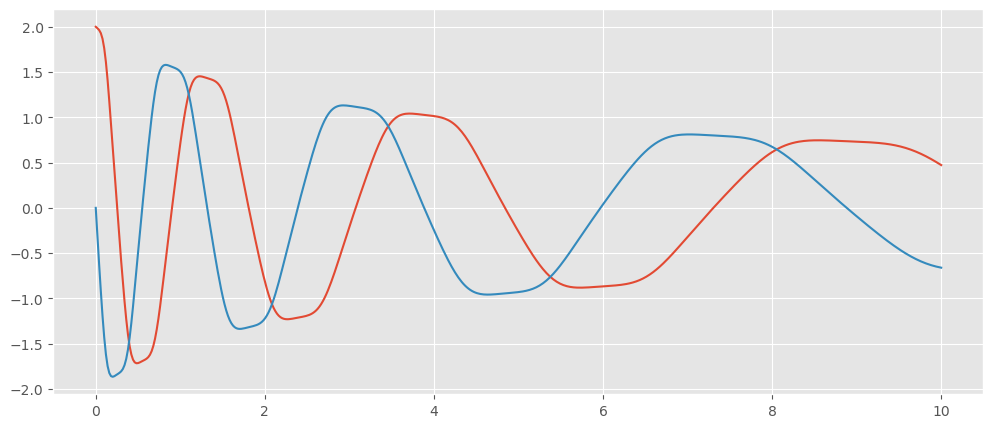

In [3]:
t_grid = jnp.linspace(0,t1,500)
x_vals = jax.vmap(sol.evaluate)(t_grid)

plt.figure(figsize=(12,5))
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])

In [23]:
trajectory_model = CholDataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.,feature_map=PolyLib(3))
optsettings = LMSettings(
    max_iter = 1000,
    show_progress=False,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
    print_every = 100,
)
data_weight =  10.
colloc_weight = 1e5
sparsifier = pySindySparsifier(
    # STLSQ(0.05,20.)
    SR3(reg_weight_lam=1.,regularizer='L1',relax_coeff_nu=1.,normalize_columns=True,max_iter = 1000)
    )

# sparsifier = NoSparsifier()

optimizer = AlternatingActiveSetLMSolver(
        beta_reg=1e-5,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)


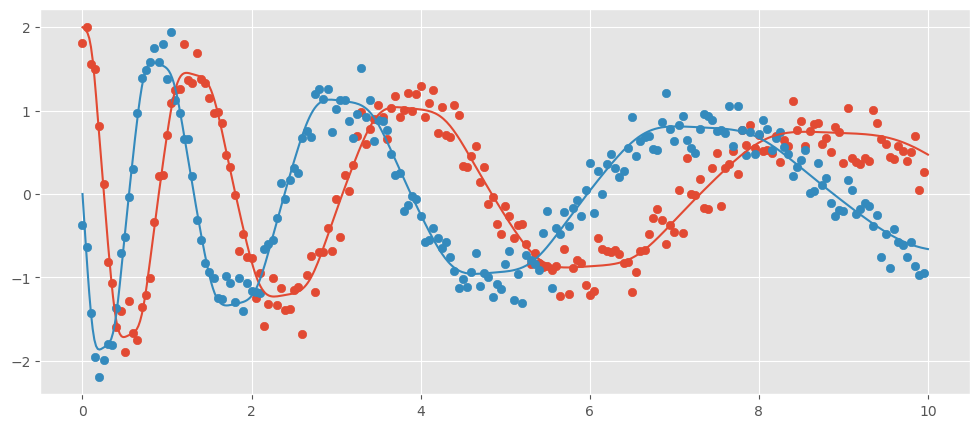

In [24]:
t_train = jnp.arange(0,t1,dt_train)
x_train_true = jax.vmap(sol.evaluate)(t_train)

noise_sigma = 0.2
x_train = x_train_true + noise_sigma * jax.random.normal(key(111),(x_train_true.shape))

plt.figure(figsize=(12,5))
plt.scatter(t_train,x_train[:,0])
plt.scatter(t_train,x_train[:,1])
plt.plot(t_grid,x_vals[:,0])
plt.plot(t_grid,x_vals[:,1])
plt.show()


In [26]:
t_colloc,w_colloc = jsindy.util.get_collocation_points_weights(t_train,500,bleedout_nodes=5)
model.fit(
    t_train,
    x_train,
    t_colloc = t_colloc,
    w_colloc = w_colloc
)

model.print()

{'show_progress': False, 'sigma2_est': Array(0.03952085, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.196 x^3 + 1.937 y^3
(y)' = -0.103 x^2 + -1.976 x^3 + -0.139 x y^2


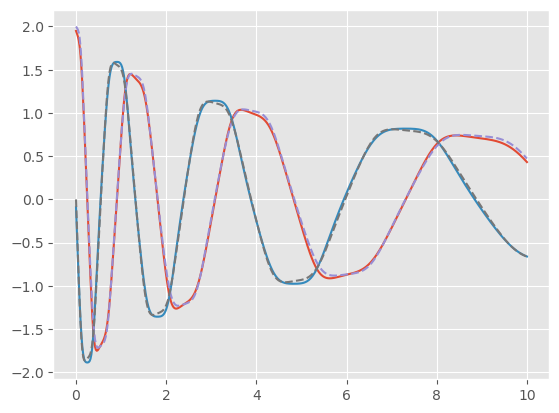

In [27]:
plt.plot(t_grid,model.predict_state(t_grid))
plt.plot(t_grid,x_vals,ls = '--')

In [28]:
true_theta = jnp.array(
    [[ 0.        ,  0.        ],
    [ 0.        , 0.    ],
    [0. ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [-0.1, -2.],
    [ 0.        ,  0.        ],
    [ 0.        ,  0.        ],
    [ 2., -0.1]])

In [29]:
noise_vals = jnp.array([0.02,0.04,0.08,0.16,0.32,0.64])


In [30]:
all_xpreds = []
all_xdot_preds = []
all_thetas = []


num_repeats = 32
all_theta_errors = jnp.zeros((num_repeats,len(noise_vals)))
all_x_errors = jnp.zeros((num_repeats,len(noise_vals)))
all_keys = jax.random.split(key(3184),num_repeats)


for repetition in range(num_repeats):
    print(repetition)
    for s,noise_sigma in enumerate(noise_vals):
        x_train = x_train_true + noise_sigma * jax.random.normal(all_keys[repetition],(x_train_true.shape))
        model.fit(t_train,x_train)
        model.print()

        xpred = model.predict_state(t_grid)
        all_theta_errors = all_theta_errors.at[repetition,s].set(
            jnp.linalg.norm(true_theta - model.theta)/jnp.linalg.norm(true_theta))
        
        all_x_errors = all_x_errors.at[repetition,s].set(
            jnp.sqrt(jnp.mean((x_vals - xpred)**2))/jnp.std(x_vals))
    
        # all_xpreds.append(model.predict_state(t_grid))
        # all_xdot_preds.append(model.traj_model.derivative(t_grid,model.z))
        # all_thetas.append(model.theta)

0


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00048178, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.097 x^3 + 1.993 y^3
(y)' = -2.002 x^3 + -0.103 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00169942, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.596 x y^2 + 2.019 y^3
(y)' = -2.020 x^3
{'show_progress': False, 'sigma2_est': Array(0.00649695, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.284 x y^2 + 1.972 y^3
(y)' = -2.014 x^3 + -0.315 x^2 y
{'show_progress': False, 'sigma2_est': Array(0.02611688, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.219 x^2 y + -0.258 x y^2 + 1.998 y^3
(y)' = -2.071 x^3 + -0.344 x^2 y
{'show_progress': False, 'sigma2_est': Array(0.10347525, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.198 x^3 + -0.422 x^2 y + -0.532 x y^2 + 1.999 y^3
(y)' = -2.164 x^3 + -0.684 x^2 y
{'show_progress': False, 'sigma2_est': Array(0.411301

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00042221, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 2.014 y^3
(y)' = -1.998 x^3 + -0.101 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1576.311487383484
{'show_progress': False, 'sigma2_est': Array(0.00157415, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 2.028 y^3
(y)' = -1.997 x^3 + -0.101 y^3
{'show_progress': False, 'sigma2_est': Array(0.0063078, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.103 x^3 + 0.253 x^2 y + 1.944 y^3
(y)' = -1.888 x^3 + -0.198 x y^2 + -0.100 y^3
{'show_progress': False, 'sigma2_est': Array(0.02359026, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.185 y^2 + 0.508 x^2 y + 1.918 y^3
(y)' = -0.084 x + -1.726 x^3 + -0.329 x y^2 + -0.207 y^3
{'show_progress': False, 'sigma2_est': Array(0.09291541, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
(x)' = -0.384 y^2 + 0.988 x^2 y + 1.893 y^3
(y)' = -0.221 x + -1.449 x^3 + -0.532 x y^2 + -0.213 y^3
{'show_progre

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00045725, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.096 x^3 + 2.008 y^3
(y)' = -1.994 x^3 + -0.104 y^3
{'show_progress': False, 'sigma2_est': Array(0.00174037, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.093 x^3 + 2.016 y^3
(y)' = -1.989 x^3 + -0.108 y^3
{'show_progress': False, 'sigma2_est': Array(0.00706377, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.199 x^3 + 2.034 y^3
(y)' = -1.974 x^3
{'show_progress': False, 'sigma2_est': Array(0.02606644, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.118 x^3 + 2.072 y^3
(y)' = -0.116 x^2 + -1.946 x^3 + 0.165 x^2 y + -0.138 y^3
{'show_progress': False, 'sigma2_est': Array(0.0997715, dtype=float64), 'data_weig

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1881.7372536935347
{'show_progress': False, 'sigma2_est': Array(0.00045319, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.104 x^3 + 1.998 y^3
(y)' = -2.000 x^3 + -0.096 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1559.8671634591838
{'show_progress': False, 'sigma2_est': Array(0.00170318, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.199 x^3 + 1.996 y^3
(y)' = -1.998 x^3
{'show_progress': False, 'sigma2_est': Array(0.00671868, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.145 x^3 + -0.163 x y^2 + 1.996 y^3
(y)' = -2.001 x^3
{'show_progress': False, 'sigma2_est': Array(0.02464847, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.140 x^3 + -0.176 x y^2 + 1.989 y^3
(y)' = -2.001 x^3
{'show_progress': False, 'sigma2_est': Array(0.09490399, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.600 x y^2 + 2.061 y^3
(y)' = 0.141 x^2 + -2.109 x^3 + -0.430 x^2 y + 0.309 x y^2 + 0.135 y^3
{'show_progress': False, 'sigma2_est': Arra

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1831.8116065685908
{'show_progress': False, 'sigma2_est': Array(0.00056585, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 2.000 y^3
(y)' = -2.003 x^3 + -0.100 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.0020802, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.101 x^3 + 2.001 y^3
(y)' = -2.006 x^3 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00787417, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.102 x^3 + 0.219 x^2 y + 1.886 y^3
(y)' = -1.900 x^3 + -0.247 x y^2 + -0.098 y^3
{'show_progress': False, 'sigma2_est': Array(0.0289143, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.096 x^3 + 0.370 x^2 y + 1.810 y^3
(y)' = -1.836 x^3 + -0.424 x y^2 + -0.103 y^3
{'show_progress': False, 'sigma2_est': Array(0.11220231, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.077 x^3 + 0.598 x^2 y + 1.700 y^3
(y)' = -1.744 x^3 + -0.705 x y^2 + -0.122 y^3
{'show_prog

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00054431, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.104 x^3 + 1.993 y^3
(y)' = -2.020 x^3 + -0.097 y^3
{'show_progress': False, 'sigma2_est': Array(0.00210389, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.202 x^3 + 1.987 y^3
(y)' = -2.037 x^3
{'show_progress': False, 'sigma2_est': Array(0.00809221, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.205 x^3 + 1.974 y^3
(y)' = -2.078 x^3
{'show_progress': False, 'sigma2_est': Array(0.03008296, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.211 x^3 + 1.948 y^3
(y)' = -2.163 x^3
{'show_progress': False, 'sigma2_est': Array(0.11638576, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Fa

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00042356, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.101 x^3 + 2.013 y^3
(y)' = -1.994 x^3 + -0.099 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00153417, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.102 x^3 + 2.026 y^3
(y)' = -1.988 x^3 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00633188, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 0.171 x^2 y + 1.968 y^3
(y)' = -1.898 x^3 + -0.164 x y^2 + -0.096 y^3
{'show_progress': False, 'sigma2_est': Array(0.02368412, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.407 x^2 y + 1.914 y^3
(y)' = -1.783 x^3 + -0.399 x y^2 + -0.207 y^3
{'show_progress': False, 'sigma2_est': Array(0.0924731, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.586 x^2 y + 1.940 y^3
(y)' = -1.677 x^3 + -0.552 x y^2 + -0.213 y^3
{'show_progress': False, 'sigma2_est

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1898.4262140752617
{'show_progress': False, 'sigma2_est': Array(0.00042378, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.020 x^3 + 1.909 y^3
(y)' = -1.926 x^3 + -0.013 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00161892, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 1.993 y^3
(y)' = -2.012 x^3 + -0.100 y^3
{'show_progress': False, 'sigma2_est': Array(0.00677716, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.201 x^3 + 0.215 x^2 y + 1.881 y^3
(y)' = -1.919 x^3 + -0.208 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02551587, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.202 x^3 + 0.413 x^2 y + 1.776 y^3
(y)' = -1.852 x^3 + -0.401 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09973311, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.090 x^3 + 0.773 x^2 y + 1.602 y^3
(y)' = 0.117 x^2 + -1.771 x^3 + -0.340 x^2 y + -0.709 x y^2
{'show_progress': Fal

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1883.7281386517236
{'show_progress': False, 'sigma2_est': Array(0.00046295, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.103 x^3 + 1.988 y^3
(y)' = -2.011 x^3 + -0.096 y^3
{'show_progress': False, 'sigma2_est': Array(0.00167943, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 1.976 y^3
(y)' = -2.022 x^3 + -0.093 y^3
{'show_progress': False, 'sigma2_est': Array(0.00664077, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.200 x^3 + 1.953 y^3
(y)' = -2.041 x^3
{'show_progress': False, 'sigma2_est': Array(0.02482634, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.201 x^3 + 1.903 y^3
(y)' = -2.088 x^3
{'show_progress': False, 'sigma2_est': Array(0.09602228, dtype=float64), 'data_weight': 10.0, 'colloc_

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00049227, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 1.983 y^3
(y)' = -2.007 x^3 + -0.094 y^3
{'show_progress': False, 'sigma2_est': Array(0.00187262, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.111 x^3 + 1.967 y^3
(y)' = -2.014 x^3 + -0.088 y^3
{'show_progress': False, 'sigma2_est': Array(0.00720566, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.201 x^3 + 1.934 y^3
(y)' = -2.026 x^3
{'show_progress': False, 'sigma2_est': Array(0.02686358, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.202 x^3 + 1.871 y^3
(y)' = -2.055 x^3
{'show_progress': False, 'sigma2_est': Array(0.10434212, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
L

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.0005626, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.992 y^3
(y)' = -2.005 x^3 + -0.101 y^3
{'show_progress': False, 'sigma2_est': Array(0.00209367, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.984 y^3
(y)' = -2.010 x^3 + -0.101 y^3
{'show_progress': False, 'sigma2_est': Array(0.00806385, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.349 x^2 y + 1.798 y^3
(y)' = -1.854 x^3 + -0.389 x y^2 + -0.199 y^3
{'show_progress': False, 'sigma2_est': Array(0.02930262, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
(x)' = 0.359 x^2 y + 1.752 y^3
(y)' = -1.867 x^3 + -0.276 x^2 y + -0.427 x y^2 + -0.110 y^3
{'show_progress': False, 'sigma2_est': Array(0.11415223, dtype=float64), 'data_weight': 10.0, 

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00059164, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.089 x^3 + 2.011 y^3
(y)' = -2.002 x^3 + -0.111 y^3
{'show_progress': False, 'sigma2_est': Array(0.00210383, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 2.028 y^3
(y)' = -2.012 x^3 + -0.202 y^3
{'show_progress': False, 'sigma2_est': Array(0.00767304, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 2.049 y^3
(y)' = -2.015 x^3 + -0.204 y^3
{'show_progress': False, 'sigma2_est': Array(0.02842261, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.237 x^2 y + 1.970 y^3
(y)' = -1.912 x^3 + -0.227 x y^2 + -0.207 y^3
{'show_progress': False, 'sigma2_est': Array(0.11044677, dtype=float64), 'data_weight': 10.0, 'colloc_weig

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00054017, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.984 y^3
(y)' = -2.015 x^3 + -0.101 y^3
{'show_progress': False, 'sigma2_est': Array(0.00206063, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.098 x^3 + 1.967 y^3
(y)' = -2.031 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.00818232, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.101 x^3 + 1.935 y^3
(y)' = -2.062 x^3 + -0.098 y^3
{'show_progress': False, 'sigma2_est': Array(0.03001569, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.289 x y^2 + 1.873 y^3
(y)' = -2.131 x^3 + -0.096 y^3
{'show_progress': False, 'sigma2_est': Array(0.11482872, dtype=float64), 'data_weight': 10.0, 

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.000477, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.991 y^3
(y)' = -1.996 x^3 + -0.100 y^3
{'show_progress': False, 'sigma2_est': Array(0.00174088, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.199 x^3 + 1.983 y^3
(y)' = -1.989 x^3
{'show_progress': False, 'sigma2_est': Array(0.00702538, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.198 x^3 + 1.966 y^3
(y)' = -1.980 x^3
{'show_progress': False, 'sigma2_est': Array(0.0275837, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.152 x^3 + -0.129 x y^2 + 1.936 y^3
(y)' = -1.965 x^3
{'show_progress': False, 'sigma2_est': Array(0.10645261, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Li

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1860.4763843311416
{'show_progress': False, 'sigma2_est': Array(0.00051649, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 1.993 y^3
(y)' = -2.001 x^3 + -0.094 y^3
{'show_progress': False, 'sigma2_est': Array(0.00188006, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.200 x^3 + 1.986 y^3
(y)' = -2.000 x^3
{'show_progress': False, 'sigma2_est': Array(0.00692068, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.200 x^3 + 1.972 y^3
(y)' = -2.003 x^3
{'show_progress': False, 'sigma2_est': Array(0.02558295, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.200 x^3 + 1.943 y^3
(y)' = -2.009 x^3
{'show_progress': False, 'sigma2_est': Array(0.09974469, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 1000

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00042449, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 1.999 y^3
(y)' = -1.994 x^3 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00156972, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 1.997 y^3
(y)' = -1.988 x^3 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00689081, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.104 x^3 + 1.995 y^3
(y)' = -1.976 x^3 + -0.094 y^3
{'show_progress': False, 'sigma2_est': Array(0.02562306, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.197 x^3 + 0.123 x^2 y + 1.962 y^3
(y)' = -1.920 x^3
{'show_progress': False, 'sigma2_est': Array(0.09751173, dtype=float64), 'data_weight': 10.0, '

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1865.6145056315017
{'show_progress': False, 'sigma2_est': Array(0.0005318, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.098 x^3 + 2.002 y^3
(y)' = -2.003 x^3 + -0.102 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00184807, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.096 x^3 + 2.005 y^3
(y)' = -2.006 x^3 + -0.104 y^3
{'show_progress': False, 'sigma2_est': Array(0.00702664, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.094 x^3 + 0.240 x^2 y + 1.911 y^3
(y)' = -1.917 x^3 + -0.160 x y^2 + -0.106 y^3
{'show_progress': False, 'sigma2_est': Array(0.02624022, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.431 x^2 y + -0.312 x y^2 + 1.854 y^3
(y)' = -0.060 x + -1.819 x^3 + -0.301 x^2 y + -0.238 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10315568, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.123 x^2 + -0.352 x y + 0.853 x^2 y + -0.388 x y^2 + 1.753 y^3
(y)' = -0.15

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1907.486163228236
{'show_progress': False, 'sigma2_est': Array(0.0004465, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 2.012 y^3
(y)' = -1.991 x^3 + -0.095 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.0015964, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.110 x^3 + 2.024 y^3
(y)' = -1.981 x^3 + -0.090 y^3
{'show_progress': False, 'sigma2_est': Array(0.00612226, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.198 x^3 + 2.050 y^3
(y)' = -1.960 x^3
{'show_progress': False, 'sigma2_est': Array(0.02310588, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.197 x^3 + 0.162 x^2 y + 2.023 y^3
(y)' = -1.853 x^3 + -0.136 x y^2
{'show_progress': False, 'sigma2_est': Array(0.09070909, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.191 x^3 + 2.215 y^3
(y)' = -0.149 x^2 + -1.833 x^3
{'show_progress': False, 'sigma2_est': Array(0.36090555, dtype=float64), 'data_weight': 10.0, 

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1835.8197104211567
{'show_progress': False, 'sigma2_est': Array(0.00054609, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 2.008 y^3
(y)' = -2.008 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.00200459, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.097 x^3 + 2.015 y^3
(y)' = -2.016 x^3 + -0.105 y^3
{'show_progress': False, 'sigma2_est': Array(0.00842653, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.203 x^3 + 2.032 y^3
(y)' = -2.028 x^3
{'show_progress': False, 'sigma2_est': Array(0.03080899, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.207 x^3 + 2.064 y^3
(y)' = -2.059 x^3
{'show_progress': False, 'sigma2_est': Array(0.11842806, dtype=float64), 'data_weight': 10.0, 'colloc_

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00048622, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.985 y^3
(y)' = -2.018 x^3 + -0.101 y^3
{'show_progress': False, 'sigma2_est': Array(0.0017557, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.098 x^3 + 1.970 y^3
(y)' = -2.037 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.00707648, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.101 x^3 + 1.942 y^3
(y)' = -2.075 x^3 + -0.100 y^3
{'show_progress': False, 'sigma2_est': Array(0.02631818, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.097 x^3 + 0.191 x^2 y + 1.776 y^3
(y)' = 0.165 x^2 + -2.064 x^3 + -0.243 x y^2 + -0.105 y^3
{'show_progress': False, 'sigma2_est': Array(0.1012561, 

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00048547, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.995 y^3
(y)' = -2.005 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.00180329, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.097 x^3 + 1.989 y^3
(y)' = -2.010 x^3 + -0.103 y^3
{'show_progress': False, 'sigma2_est': Array(0.00699624, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.978 y^3
(y)' = -2.020 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.02598748, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.083 x^3 + 1.961 y^3
(y)' = -0.120 x^2 + -2.031 x^3 + -0.118 y^3
{'show_progress': False, 'sigma2_est': Array(0.10071878, dtype=float64), 'data_weig

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00048627, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.991 y^3
(y)' = -2.008 x^3 + -0.101 y^3
{'show_progress': False, 'sigma2_est': Array(0.0017637, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.098 x^3 + 1.982 y^3
(y)' = -2.016 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.00700209, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.201 x^3 + 1.965 y^3
(y)' = -2.030 x^3
{'show_progress': False, 'sigma2_est': Array(0.02633591, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.097 y + -0.207 x^3 + 0.225 x^2 y + 1.762 y^3
(y)' = -1.962 x^3 + -0.145 x y^2
{'show_progress': False, 'sigma2_est': Array(0.10138492, dtype=float64), 'data_weigh

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1871.6836648085296
{'show_progress': False, 'sigma2_est': Array(0.00049969, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 1.998 y^3
(y)' = -2.015 x^3 + -0.096 y^3
{'show_progress': False, 'sigma2_est': Array(0.00182198, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.202 x^3 + 1.996 y^3
(y)' = -2.027 x^3
{'show_progress': False, 'sigma2_est': Array(0.00675025, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.204 x^3 + 0.190 x^2 y + 1.902 y^3
(y)' = -1.969 x^3 + -0.174 x y^2
{'show_progress': False, 'sigma2_est': Array(0.02473111, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.230 x y + -0.208 x^3 + 0.335 x^2 y + 1.813 y^3
(y)' = 0.298 x^2 + -0.136 y^2 + -1.993 x^3 + -0.308 x y^2
{'show_progress': Fa

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00047124, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 1.998 y^3
(y)' = -1.989 x^3 + -0.093 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1518.0686955008537
{'show_progress': False, 'sigma2_est': Array(0.00188083, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.198 x^3 + 1.996 y^3
(y)' = -1.975 x^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00737189, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.196 x^3 + 1.993 y^3
(y)' = -1.954 x^3
{'show_progress': False, 'sigma2_est': Array(0.02761206, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.192 x^3 + 1.985 y^3
(y)' = -1.912 x^3
{'show_progress': False, 'sigma2_est': Array(0.10609595, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.102 y + -0.377 x y + 0.200 y^2 + -0.316 x^3 + 0.271 x y^2 + 1.897 y^3
(y)' = 0.206 x y + 0.156 y^2 + -1.858 x^3 + 0.408 x^2 y + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.41261516, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.226 x + 0.679 y + -0.891 x y + 0.563 y^2 + -0.154 x^3 + -0.285 x^2 y + 1.677 y^3
(y)' 

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1870.3459979449428
{'show_progress': False, 'sigma2_est': Array(0.00050868, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.094 x^3 + 2.001 y^3
(y)' = -1.993 x^3 + -0.105 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1542.138826135207
{'show_progress': False, 'sigma2_est': Array(0.00182793, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.089 x^3 + 2.002 y^3
(y)' = -1.986 x^3 + -0.111 y^3
{'show_progress': False, 'sigma2_est': Array(0.00706746, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.080 x^3 + 2.004 y^3
(y)' = -1.972 x^3 + -0.119 y^3
{'show_progress': False, 'sigma2_est': Array(0.02674166, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 2.011 y^3
(y)' = -1.951 x^3 + -0.199 y^3
{'show_progress': False, 'sigma2_est': Array(0.10516467, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.107 y^2 + 2.059 y^3
(y)' = -1.947 x^3 + 0.193 x y^2 + -0.194 y^3
{'show_progress': False, 'sigma2_est': Array(0.41797185, dtype=float64), 'da

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00049049, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.997 y^3
(y)' = -2.003 x^3 + -0.101 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00178486, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
(x)' = -0.099 x^3 + 1.994 y^3
(y)' = -2.006 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.00704993, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.099 x^3 + 1.987 y^3
(y)' = -2.012 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.02699385, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.203 x^3 + 0.202 x^2 y + 0.322 x y^2 + 1.934 y^3
(y)' = -1.978 x^3 + 0.252 x^2 y + -0.189 y^3
{'show_progress': False, 'sigma2_est': Array(0.10412873, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.720 x y + -0.385 x^3 + 0.752 x y^2 + 2.135 y^3
(y)' = -0.600 x^2 + 0.350 y^2 + -2.175 x^3 + 0.503 x^2 y + 0.451 x y^2 + -0.226 y^3
{'show_progress': 

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00050711, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 1.996 y^3
(y)' = -1.997 x^3 + -0.100 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00190718, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 1.992 y^3
(y)' = -1.993 x^3 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00770375, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.108 x^3 + 1.985 y^3
(y)' = -1.986 x^3 + -0.090 y^3
{'show_progress': False, 'sigma2_est': Array(0.02757101, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.215 x^3 + 0.190 x^2 y + 0.415 x y^2 + 1.899 y^3
(y)' = -1.885 x^3 + 0.264 x^2 y + -0.166 x y^2 + -0.208 y^3
{'show_progress': False, 'sigma2_est': Array(0.10407093, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.156 y^2 + -0.320 x^3 + 0.289 x^2 y + 0.806 x y^2 + 1.852 y^3
(y)' = -1.817 x^3 + 0.504 x^2 

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00053888, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.100 x^3 + 2.020 y^3
(y)' = -1.978 x^3 + -0.099 y^3
{'show_progress': False, 'sigma2_est': Array(0.00193994, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.197 x^3 + 2.039 y^3
(y)' = -1.953 x^3
{'show_progress': False, 'sigma2_est': Array(0.00727837, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.125 x^3 + 2.080 y^3
(y)' = -1.910 x^3 + -0.211 x^2 y
{'show_progress': False, 'sigma2_est': Array(0.02721871, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.222 x y^2 + 2.163 y^3
(y)' = -1.838 x^3 + -0.371 x^2 y
{'show_progress': False, 'sigma2_est': Array(0.10539378, dtype=float64), 'data_weight': 10.0, 'colloc_w

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1835.9778636422334
{'show_progress': False, 'sigma2_est': Array(0.00055516, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 2.000 y^3
(y)' = -1.998 x^3 + -0.094 y^3
{'show_progress': False, 'sigma2_est': Array(0.00206762, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.199 x^3 + 2.000 y^3
(y)' = -1.994 x^3
{'show_progress': False, 'sigma2_est': Array(0.00831533, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
(x)' = -0.199 x^3 + 2.000 y^3
(y)' = -1.990 x^3
{'show_progress': False, 'sigma2_est': Array(0.03132582, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
(x)' = -0.198 x^3 + 2.000 y^3
(y)' = -1.983 x^3
{'show_progress': False, 'sigma2_est': Array(0.12052226, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.182 x^2 + -0.354 y^2 + -0.200

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00049891, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.098 x^3 + 1.997 y^3
(y)' = -1.993 x^3 + -0.101 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00187434, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.097 x^3 + 1.993 y^3
(y)' = -1.986 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.00708048, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.096 x^3 + 1.987 y^3
(y)' = -1.972 x^3 + -0.102 y^3
{'show_progress': False, 'sigma2_est': Array(0.02677845, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.191 x^3 + 0.273 x^2 y + 0.283 x y^2 + 1.861 y^3
(y)' = -0.164 x + -1.708 x^3 + 0.280 x^2 y + -0.163 x y^2 + -0.199 y^3
{'show_progress': False, 'sigma2_est': Array(0.1036828, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.279 x^3 + 0.497 x^2 y + 0.593 x y^2 + 1.747 y^3
(y)' = -0.372 x + 0.146 x^2 + -1

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


{'show_progress': False, 'sigma2_est': Array(0.00045512, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.106 x^3 + 2.006 y^3
(y)' = -2.005 x^3 + -0.095 y^3


/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1569.8235932253413
{'show_progress': False, 'sigma2_est': Array(0.00163185, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.201 x^3 + 2.013 y^3
(y)' = -2.008 x^3
{'show_progress': False, 'sigma2_est': Array(0.00630367, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.203 x^3 + 2.026 y^3
(y)' = -2.018 x^3
{'show_progress': False, 'sigma2_est': Array(0.02415442, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.206 x^3 + 2.052 y^3
(y)' = -2.039 x^3
{'show_progress': False, 'sigma2_est': Array(0.0941008, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = 0.353 x y + -0.200 x^3 + -0.379 x^2 y + 2.217 y^3
(y)' = -0.225 y^2 + -2.136 x^3
{'show_progress': False, 'sigma2_est': Array(0.37398723, dtype=float64), 'data_weight': 1

/mnt/share/homes/owlx/sindy_work/jsindy/jsindy/kernels/tree_opt.py:74: UserWarning: Line search failed
  warn("Line search failed")


-1911.080738502564
{'show_progress': False, 'sigma2_est': Array(0.00041652, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.103 x^3 + 1.992 y^3
(y)' = -2.004 x^3 + -0.097 y^3
{'show_progress': False, 'sigma2_est': Array(0.00155333, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.105 x^3 + 1.984 y^3
(y)' = -2.007 x^3 + -0.095 y^3
{'show_progress': False, 'sigma2_est': Array(0.00627997, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.200 x^3 + 1.967 y^3
(y)' = -2.013 x^3
{'show_progress': False, 'sigma2_est': Array(0.02384461, dtype=float64), 'data_weight': 10.0, 'colloc_weight': 100000.0}
Line Search Failed!
Final Iteration Results
(x)' = -0.239 x y^2 + 1.936 y^3
(y)' = -2.040 x^3 + -0.360 x^2 y
{'show_progress': False, 'sigma2_est': Array(0.09259976, dtype=float64), 'data_weight'

In [33]:
jnp.save('all_theta_errors.npy', all_theta_errors)
jnp.save('all_x_errors.npy', all_x_errors)

In [34]:
all_theta_errors = jnp.load('all_theta_errors.npy')
all_x_errors = jnp.load('all_x_errors.npy')

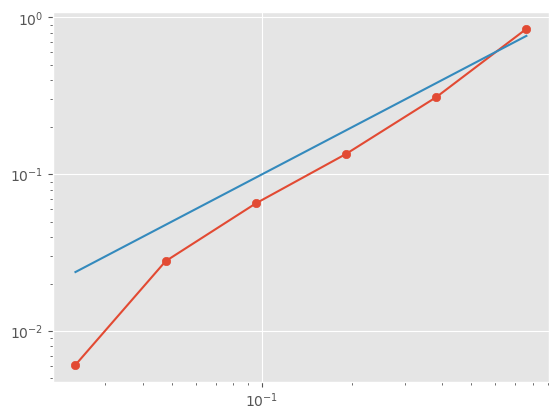

In [35]:
plt.plot(noise_vals/jnp.std(x_train_true),jnp.mean(all_theta_errors,axis=0))
plt.scatter(noise_vals/jnp.std(x_train_true),jnp.mean(all_theta_errors,axis=0))

plt.xscale('log')
plt.yscale('log')
plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))
plt.show()

# plt.plot(noise_vals/jnp.std(x_train_true),jnp.mean(all_x_errors,axis=0))
# plt.scatter(noise_vals/jnp.std(x_train_true),jnp.mean(all_x_errors,axis=0))

# plt.xscale('log')
# plt.yscale('log')
# plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))

# plt.show()


In [36]:
from pysindy import EnsembleOptimizer
from pysindy.differentiation import SmoothedFiniteDifference
import pysindy as ps
import numpy as np

In [37]:
library = ps.PolynomialLibrary(3)
optimizer = ps.STLSQ(0.09,5.)
diff_method = ps.SmoothedFiniteDifference()
ps_model = ps.SINDy(
    feature_library=library,
    optimizer=optimizer,
    differentiation_method=diff_method
    )

ps_errors = []
for noise_sigma in noise_vals:
    x_train = x_train_true + noise_sigma * jax.random.normal(key(123),(x_train_true.shape))
    ps_model.fit(np.array(x_train),np.array(t_train))
    theta = ps_model.coefficients().T

    ps_errors.append(jnp.linalg.norm(true_theta - theta)/jnp.linalg.norm(true_theta))
ps_errors = jnp.array(ps_errors)

In [38]:
odr_coef_error = jnp.array(loadtxt("coef_error.csv",delimiter = ','))
odr_x_error = jnp.array(loadtxt("x_error.csv",delimiter = ','))


odr_mean_x = jnp.mean(odr_coef_error[:-1],axis=0)
odr_mean_coef = jnp.mean(odr_x_error[:-1],axis=0)

odr_median_coef = jnp.median(odr_x_error[:-1],axis=0)

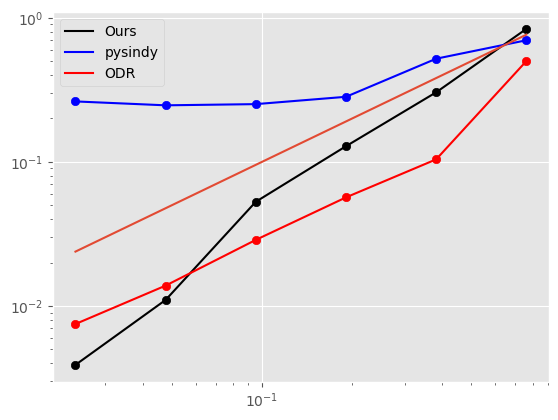

In [39]:
plt.plot(noise_vals/jnp.std(x_train_true),jnp.median(all_theta_errors,0),c='black',label = "Ours")
plt.scatter(noise_vals/jnp.std(x_train_true),jnp.median(all_theta_errors,0),c='black')

plt.plot(noise_vals/jnp.std(x_train_true),ps_errors,c='blue',label = 'pysindy')
plt.scatter(noise_vals/jnp.std(x_train_true),ps_errors,c='blue')

plt.plot(noise_vals/jnp.std(x_train_true),odr_median_coef,c='red',label = 'ODR')
plt.scatter(noise_vals/jnp.std(x_train_true),odr_median_coef,c='red')


plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))


plt.xscale('log')
plt.yscale('log')


plt.legend()
plt.show()


In [40]:
plt.plot(noise_vals/jnp.std(x_train_true),x_errors,c='black',label = "Ours")
plt.scatter(noise_vals/jnp.std(x_train_true),x_errors,c='black')

plt.plot(noise_vals/jnp.std(x_train_true),odr_mean_x,c='red',label = 'ODR')
plt.scatter(noise_vals/jnp.std(x_train_true),odr_mean_x,c='red')


plt.plot(noise_vals/jnp.std(x_train_true),noise_vals/jnp.std(x_train_true))


plt.xscale('log')
plt.yscale('log')


plt.legend()
plt.show()


NameError: name 'x_errors' is not defined